# Image Manipulation

Export uz as pkl file

In [2]:
import os, os.path
import time

import cv2
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
# %matplotlib qt

import seaborn as sns
from astropy import units as u

%matplotlib inline

In [3]:
# Import Images

img_folder = os.path.join(os.getcwd(),'test files') #if images are in the same folder as the notebook

def imgs_import(img_folder):
    imgs_loc = []
    for f in sorted(os.listdir(img_folder)):
        if f.endswith('.tif'):
            img_loc = os.path.join(img_folder, f)
            imgs_loc.append(img_loc)   
    return imgs_loc

In [4]:
# Crop Images
imgs_loc = imgs_import(img_folder)
imgs = [cv2.imread(img) for img in imgs_loc]


imgs_cropped = []
for img in imgs:
    img_cropped = img[0:2500,610::] # crop to make sure peel front is visible on all timepoints
    imgs_cropped.append(img_cropped)

In [5]:
# Prep Images
edges = []
idxes = []

for i in imgs_cropped: 
    # RGB 2 GRAY conversion
    img_grey = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    
    # Kernel size to remove small specks 
    ksize = 10
    ellipseKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))    
    img_WT = cv2.morphologyEx(img_grey,cv2.MORPH_OPEN, ellipseKernel) #white_tophat processed
    
    # Median Blur
    img_blur = cv2.medianBlur(img_WT,19)
    
    # Threshold to make image binary. Can change with background
    threshold = 45 
    img_BINARY = img_blur > threshold
    
    # CannyEdge to detect edges/boundaries
    edged = cv2.Canny(img_blur, 50, 250)
    edges.append(edged)
    
    idx = np.apply_along_axis(lambda a: np.flatnonzero(a)[0], 
                              axis=1, arr=edged)
    idxes.append(idx)

Original Image Shape: (4916, 1024, 3)
Cropped Image Shape: (2500, 414, 3)


Text(0.5, 1.0, 'Cropped Image')

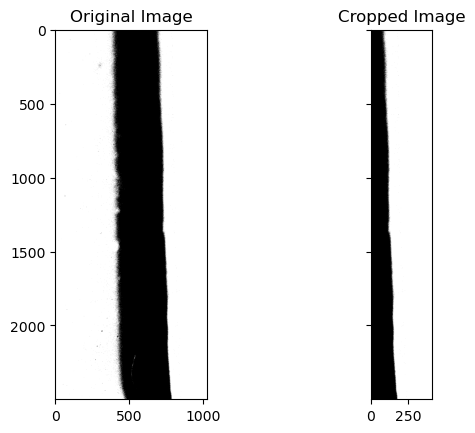

In [6]:
# Image visualization

print('Original Image Shape:',img.shape)
print('Cropped Image Shape:',img_cropped.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, 
                       sharey=True, squeeze=True)
ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cmap=plt.cm.binary)
ax[0].set_title('Original Image')

ax[1].imshow(cv2.cvtColor(img_cropped,cv2.COLOR_BGR2GRAY), cmap=plt.cm.binary)
ax[1].set_title('Cropped Image')

Text(0.5, 1.0, 'Canny Edge')

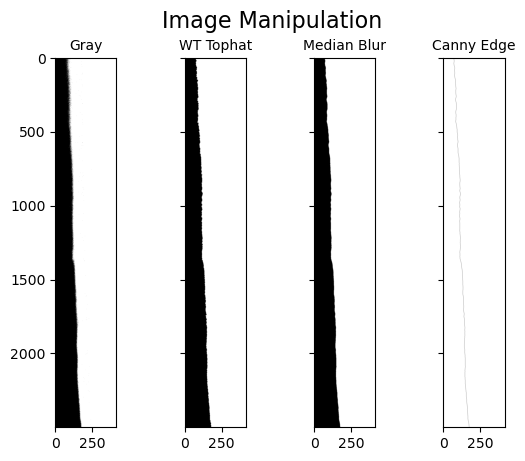

In [7]:
# 3: Image Manipulation
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True,
                       sharex=True, squeeze=True)

fig.suptitle('Image Manipulation', fontsize=16)
ax[0].imshow(img_grey, cmap=plt.cm.binary)
ax[0].set_title('Gray',fontsize=10)

ax[1].imshow(img_WT, cmap=plt.cm.binary)
ax[1].set_title('WT Tophat',fontsize=10)

ax[2].imshow(img_blur, cmap=plt.cm.binary)
ax[2].set_title('Median Blur',fontsize=10)

ax[3].imshow(edged, cmap=plt.cm.binary)
ax[3].set_title('Canny Edge',fontsize=10)


In [8]:
# Initialize arrays

Uz0 = idxes[0] # Uz @ t=0

Uz_raw = [] 
Uz_raw_um = []

px2um = 1.24 # um/px conversion

In [9]:
# Images to numbers
for _ in idxes[1:]:
    ux = _ - Uz0 # subtracting from timepoint 1 to create baseline
    Uz_raw.append(ux)
    Uz_raw_um.append(ux*px2um)


In [10]:
# Exporting via pickle

import pickle 
with open("export_uz.pkl", "wb") as f: # "wb" because we want to write in binary mode
    pickle.dump(Uz_raw_um, f)

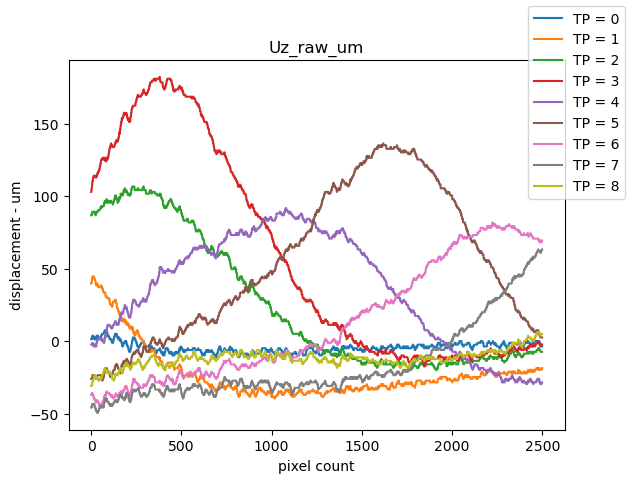

In [11]:
# Plot Uz
fig, ax = plt.subplots()

for i,u in enumerate(Uz_raw_um):
    ax.plot(u, label=f'TP = {i}')

ax.set_title('Uz_raw_um',fontsize=12)
ax.set_ylabel('displacement - um')
ax.set_xlabel('pixel count')
fig.legend()